In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Load the file into a DataFrame
netflix = pd.read_csv('/content/combined_data_1.txt', header = None, usecols=[0,1], names=['Customer_Id', 'Rating'])

# Display the first few rows of the DataFrame
print(netflix.head())

# Check the first few rows of the DataFrame to verify
print(netflix.head())


  Customer_Id  Rating
0          1:     NaN
1     1488844     3.0
2      822109     5.0
3      885013     4.0
4       30878     4.0
  Customer_Id  Rating
0          1:     NaN
1     1488844     3.0
2      822109     5.0
3      885013     4.0
4       30878     4.0


In [ ]:
netflix.isnull().sum()

,0
Customer_Id,0
Rating,4499


In [ ]:
# Find the number of null values specifically in the 'Rating' column
Movie_Count = netflix['Rating'].isna().sum()
print(f"Number of null values in the 'Rating' column: {Movie_Count}")


Number of null values in the 'Rating' column: 4499


In [ ]:
# Customer Count
Customer_count = netflix['Customer_Id'].nunique() - Movie_Count
print(f"Number of unique customers: {Customer_count}")

Number of unique customers: 470758


In [ ]:
rating_count = len(netflix) - Movie_Count
print(f"Number of ratings: {rating_count}")

Number of ratings: 24053764


In [ ]:
netflix['Rating'].value_counts()

,count
Rating,
4.0,8085741
3.0,6904181
5.0,5506583
2.0,2439073
1.0,1118186


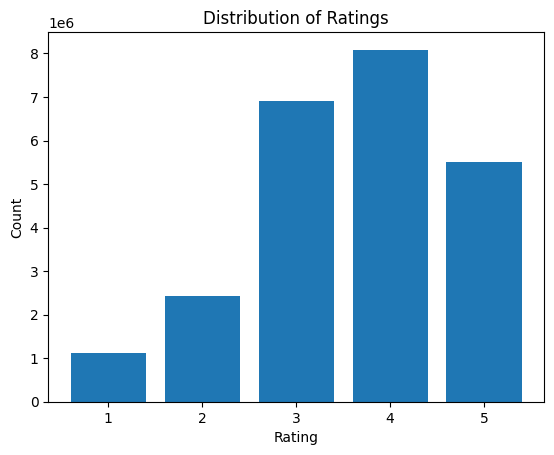

In [ ]:
import matplotlib.pyplot as plt
plt.bar(netflix['Rating'].value_counts().index, netflix['Rating'].value_counts().values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
pd_nan = pd.DataFrame(pd.isnull(netflix.Rating))
pd_nan = pd_nan[pd_nan['Rating'] == True]
pd_nan

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [ ]:
#reset index
pd_nan = pd_nan.reset_index()
pd_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [ ]:
# Reset movie_id and movie_labels
movie_id = 1
movie_labels = []
for i, j in zip(pd_nan['index'][1:], pd_nan['index'][:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_labels= np.append(movie_labels, temp)
    movie_id =movie_id + 1

# for last record
# For the last segment
temp_last = np.full((len(netflix) - pd_nan.iloc[-1, 0] - 1,), movie_id)
movie_labels = np.append(movie_labels,temp_last)

In [ ]:
netflix = netflix[pd.notnull(netflix['Rating'])]
netflix['movie_id'] = movie_labels.astype('int')
netflix['Customer_Id'] = netflix['Customer_Id'].astype('int')
netflix['Rating'] = netflix['Rating'].astype('int')
netflix.head()

,Customer_Id,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [ ]:
movie_summary = netflix.groupby('movie_id')['Rating'].agg(['count'])
movie_summary.head()

,count
movie_id,
1,547
2,145
3,2012
4,142
5,1140


In [ ]:
movie_benchmark = round(movie_summary['count'].quantile(0.6), 0)
drop_movie_list = movie_summary[movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 908.0


In [ ]:
# Filtering Customers
df_cust_summary = netflix.groupby('Customer_Id')['Rating'].agg(['count'])
df_cust_summary.head()

,count
Customer_Id,
6,153
7,195
8,21
10,49
25,4


In [ ]:
#set benchmark
cust_benchmark = round(df_cust_summary['count'].quantile(0.6), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 36.0


In [ ]:
#drop, trimming
netflix = netflix[~netflix['movie_id'].isin(drop_movie_list)]
netflix = netflix[~netflix['Customer_Id'].isin(drop_cust_list)]
print('Shape of netflix data: {}'.format(netflix.shape))
#

Shape of netflix data: (19695836, 3)


In [ ]:
#/content/movie_titles (2).csv
movie_titles = pd.read_csv('/content/movie_titles (2).csv', encoding = 'ISO-8859-1', header = None, usecols = [0,1,2], names = ['Movie_Id', 'Year', 'Name'])
movie_titles.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357288 sha256=6c5644bc72d003653f1cd55ff8cd563b6d589660d60db390fc0c826daccf87bb
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
# Define the Reader object with the appropriate rating scale
read = Reader(rating_scale=(1, 5))

# Load the dataset using the Reader object
data = Dataset.load_from_df(netflix[['Customer_Id', 'movie_id', 'Rating']][:1000000], read)

In [ ]:
model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3)

{'test_rmse': array([0.97071636, 0.96907484, 0.97105643]),
 'test_mae': array([0.75836558, 0.75709786, 0.76016425]),
 'fit_time': (17.822256565093994, 18.56856107711792, 19.58926033973694),
 'test_time': (5.370260953903198, 3.369112968444824, 4.006747722625732)}

In [ ]:
# DOING PREDICTION AND RECOMMENDATION FOR ANY RANDOM CUSTOMER #113154
user_113154 = movie_titles.copy()
user_113154

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [ ]:
user_113154 = user_113154[~user_113154['Movie_Id'].isin(drop_movie_list)]
user_113154

,Movie_Id,Year,Name
2,3,1997.0,Character
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [ ]:
#estimation score rating
user_113154['Estimate_Score'] = user_113154['Movie_Id'].apply(lambda x: model.predict(113154, x).est)
user_113154.sort_values('Estimate_Score', ascending=False)

<ipython-input-36-2c939c0f2cea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_113154['Estimate_Score'] = user_113154['Movie_Id'].apply(lambda x: model.predict(113154, x).est)


,Movie_Id,Year,Name,Estimate_Score
269,270,2001.0,Sex and the City: Season 4,4.284487
208,209,1996.0,Star Trek: Deep Space Nine: Season 5,4.232591
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,4.214296
240,241,1959.0,North by Northwest,4.182775
222,223,2003.0,Chappelle's Show: Season 1,4.176156
...,...,...,...,...
25,26,2004.0,Never Die Alone,2.837407
224,225,2004.0,The Cookout,2.734560
126,127,1987.0,Fatal Beauty,2.675146
94,95,1985.0,Dona Herlinda and Her Son,2.650201


In [ ]:
user_113154.head(10)

,Movie_Id,Year,Name,Estimate_Score
2,3,1997.0,Character,3.684515
4,5,2004.0,The Rise and Fall of ECW,3.981485
5,6,1997.0,Sick,3.113988
7,8,2004.0,What the #$*! Do We Know!?,3.199663
15,16,1996.0,Screamers,3.157089
16,17,2005.0,7 Seconds,2.970512
17,18,1994.0,Immortal Beloved,3.879954
23,24,1981.0,My Bloody Valentine,3.162966
24,25,1997.0,Inspector Morse 31: Death Is Now My Neighbour,4.065804
25,26,2004.0,Never Die Alone,2.837407
